In the last chapter, we examined and built a convolutional neural network (CNN). We even combined it with the LSTM architecture to test whether we could outperform the LSTM models. The results were mixed, as the CNN models performed worse as single-step models, performed best as multi-step models, and performed equally well as multi-output models.

Now we’ll focus entirely on the multi-step models, as all of them output the entire sequence of predictions in a single shot. We’re going to modify that behavior and gradually output the prediction sequence, using past predictions to make new predictions. That way, the model will create rolling forecasts, but using its own predictions to inform the output.

This architecture is commonly used with LSTM and is called autoregressive LSTM (ARLSTM). In this chapter, we’ll first explore the general architecture of the ARLSTM model, and then we’ll build it in Keras to see if we can build a new topperforming multi-step model.

## 17.1 Examining the ARLSTM architecture

We have built many multi-step models that all output predictions for traffic volume in the next 24 hours. Each model has generated the entire prediction sequence in a single shot, meaning that we get 24 values from the model right away.

For illustration purposes, let’s consider a simple model with only an LSTM layer. Figure 17.1 shows the general architecture of the multi-step models we have built so far. Each of them had inputs coming in, passing through a layer, whether it is LSTM, Dense, or Conv1D, and resulting in a sequence of 24 values. This type of architecture forces an output of 24 values.

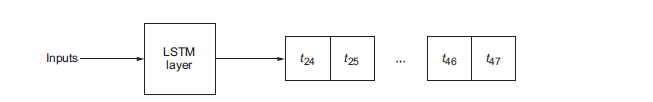

But what if we want a longer sequence? Or a shorter sequence? What if we wish to forecast the next 8 hours only, or forecast the next 48 hours? In that case, we must redo our data windows and retrain the models, which might represent quite a bit of work.

Instead, we can opt for an autoregressive deep learning model. As you can see in figure 17.2, each prediction is sent back into the model, allowing it to generate the next prediction. This process is repeated until we obtain a sequence of the desired length.

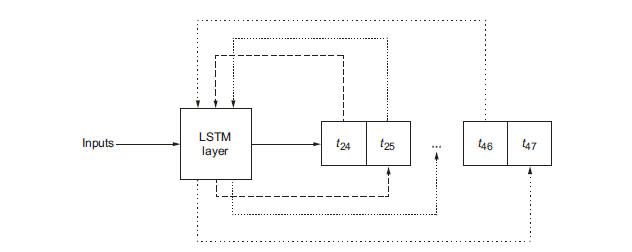

You can see how easy it becomes to generate any sequence length using an autoregressive deep learning architecture. This approach has the added advantage of allowing us to forecast time series with different scales, such as hours, days, or months, while avoiding having to retrain a new model. This is the type of architecture built by Google Deep-Mind to create WaveNet (https://deepmind.com/blog/article/wavenet-generativemodel-raw-audio), a model that generates raw audio sequences. In the context of time series, DeepAR (http://mng.bz/GEoV) is a methodology that also uses an autoregressive recurrent neural network to achieve state-of-the-art results.

Nevertheless, autoregressive deep learning models come with a major caveat, which is the accumulation of error. We have forecast many time series, and we know that there is always some discrepancy between our predictions and the actual values. That error accumulates as it is fed back into the model, meaning that later predictions will have a larger error than earlier predictions. Thus, while the autoregressive deep learning architecture seems powerful, it might not be the best solution for a particular problem. Hence the importance of using a rigorous testing protocol, which is really what we have developed since chapter 13.

Still, it is good to have this model in your toolbox of time series forecasting methods. In the next section, we’ll code an autoregressive LSTM model to produce forecasts for the next 24 hours. We’ll compare its performance to that of our previous multi-step models.

## 17.2 Building an autoregressive LSTM model

We are now ready to code our own autoregressive deep learning model in Keras. Specifically, we’ll code an ARLSTM model, since our experiments have shown that the LSTM model achieves the best performance of the multi-step models. Thus we’ll try to further improve this model by making it autoregressive.


In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

tf.random.set_seed(42)
np.random.seed(42)

train_df = pd.read_csv('./train.csv', index_col=0)
val_df = pd.read_csv('./val.csv', index_col=0)
test_df = pd.read_csv('./test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

2022-10-09 18:16:17.319264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 18:16:17.492303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 18:16:17.492371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-09 18:16:17.575985: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 18:16:18.737688: W tensorflow/stream_executor/platform/de

(33742, 8) (9641, 8) (4821, 8)


In [2]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [3]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [4]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

Next, we’ll define our window of data. In this case, we’ll reuse the window of data we used for the LSTM model. The input and label sequences will each have 24 timesteps.

We’ll specify a shift of 24 so that the model outputs 24 predictions. Our target
remains the traffic volume.

In [6]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

# Values obtained from chapter 16

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070, 0.078, 0.069]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058, 0.063, 0.055]

Now we’ll wrap our model in a class called AutoRegressive, which inherits from the Model class in Keras. This is what allows us to access inputs and outputs. That way, we’ll be able to specify that the output should become an input at each prediction step.

We’ll start by defining the \_\_init__ function in our AutoRegressive class. This function takes three parameters:
- self—References the instance of the AutoRegressive class.
- units—Represents the number of neurons in a layer.
- out_steps—Represents the length of the prediction sequence. In this case, it is 24.

Then we’ll make use of three different Keras layers: the Dense layer, the RNN layer, and the LSTMCell layer. The LSTMCell layer is a lower-level layer than the LSTM layer. It allows us to access more granular information, such as state and predictions, which we can then manipulate to feed an output back into the model as an input. As for the RNN layer, this is used to train the LSTMCell layer on the input data. Its output is then passed through the Dense layer to generate a prediction. This is the complete \_\_init__ function:

```
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
```

With the initialization done, the next step is to define a function that outputs the very first prediction. Since this is an autoregressive model, that prediction is then fed back into the model as an input to generate the next prediction. We must therefore
have a method to capture that very first forecast before entering the autoregressive loop.

Thus, we’ll define the warmup function, which replicates a single-step LSTM model. We’ll simply pass the inputs into the lstm_rnn layer, get the prediction from the Dense layer, and return both the prediction and the state.

```
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
```

Now that we have a way to capture the first prediction, we can define the call function, which will run a loop to generate the sequence of predictions with a length of out_steps. Note that the function must be named call because it is called implicitly
by Keras; naming it differently would result in an error.

Since we are using the LSTMCell class, which is a low-level class, we must manually pass in the previous state. Once the loop is finished, we stack our predictions and make sure they have the right output shape using the transpose method.

```
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions
```

The complete class is shown in the following listing.

In [7]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

We have now defined our AutoRegressive class, which implements an autoregressive LSTM model. We can use it and train a model on our data. We’ll initialize it with 32 units and an output sequence length of 24 timesteps, since the objective of the multistep model is to forecast the next 24 hours.

In [8]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

2022-10-09 18:45:49.635160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 18:45:49.635225: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 18:45:49.635255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deedevelopment): /proc/driver/nvidia/version does not exist
2022-10-09 18:45:49.635590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1053/1053 [==============================] - 32s 23ms/step - loss: 0.0571 - mean_absolute_error: 0.1931 - val_loss: 0.0464 - val_mean_absolute_error: 0.1643
Epoch 2/50
1053/1053 [==============================] - 24s 22ms/step - loss: 0.0468 - mean_absolute_error: 0.1703 - val_loss: 0.0387 - val_mean_absolute_error: 0.1519
Epoch 3/50
1053/1053 [==============================] - 23s 22ms/step - loss: 0.0443 - mean_absolute_error: 0.1636 - val_loss: 0.0364 - val_mean_absolute_error: 0.1486
Epoch 4/50
1053/1053 [==============================] - 23s 22ms/step - loss: 0.0426 - mean_absolute_error: 0.1588 - val_loss: 0.0380 - val_mean_absolute_error: 0.1456
Epoch 5/50
1053/1053 [==============================] - 23s 22ms/step - loss: 0.0414 - mean_absolute_error: 0.1554 - val_loss: 0.0352 - val_mean_absolute_error: 0.1452
Epoch 6/50
1053/1053 [==============================] - 24s 22ms/step - loss: 0.0403 - mean_absolute_error: 0.1525 - val_loss: 0.0344 - val_mean_absolute_error:

We can visualize the predictions of our model against the actual values by using the plot method from our DataWindow class.

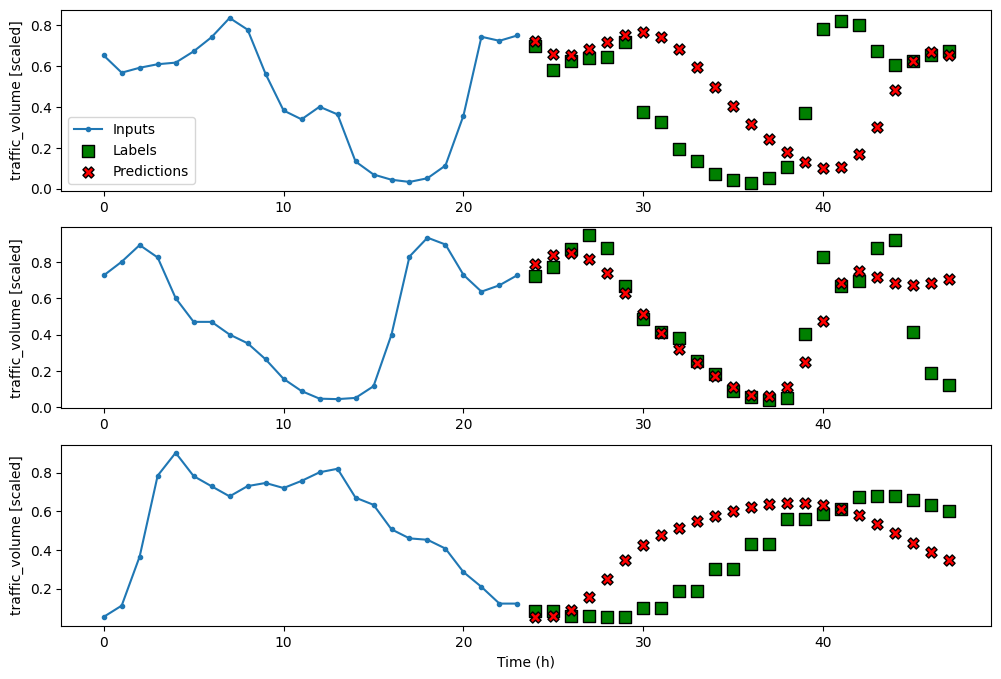

In [9]:
multi_window.plot(AR_LSTM)

This visual inspection is not sufficient to determine whether we have a new topperforming model, so we’ll display its MAE against that of all previous multi-step models. The result is shown in figure 17.4, which shows that our autoregressive LSTM model achieves an MAE of 0.063 on the validation set and 0.049 on the test set. This is a better score than the CNN, and the CNN + LSTM models, as well as the simple LSTM model. Thus, the ARLSTM model becomes the top-performing multistep model.

Always keep in mind that the performance of each model depends on the problem at stake. The takeaway here is not that the ARLSTM is always the best model, but that it is the best-performing model for this situation. For another problem, you might find another champion model. If you have been completing the exercises since chapter 13, you can already see this happening. Keep in mind that each model we have built since chapter 13 is meant to be another tool in your toolbox to help you maximize the chances of solving a time series forecasting problem.

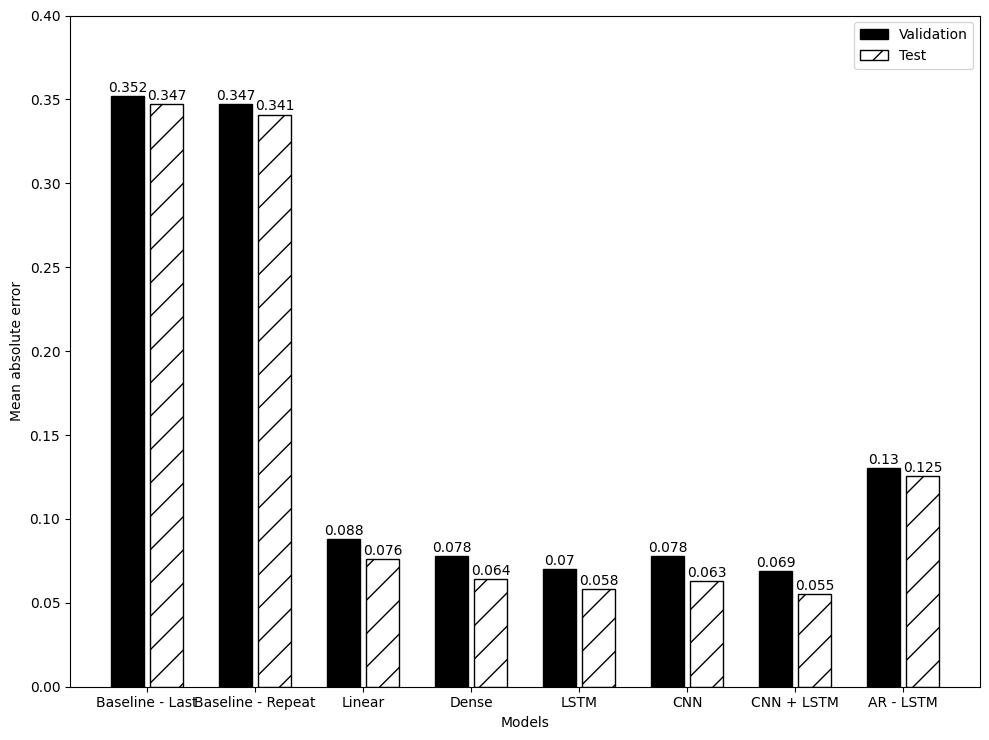

In [10]:
ms_mae_val.append(ms_val_performance['AR - LSTM'][1])
ms_mae_test.append(ms_performance['AR - LSTM'][1])

x = np.arange(8)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()